In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing
from multiprocessing.pool import ThreadPool
import copy

import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import tqdm
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgbm
#from lightgbm import LGBMClassifier as lgbm
from catboost import CatBoostRegressor as cat
from sklearn.metrics import r2_score

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA

/usr/local/lib/python3.6/dist-packages/backtesting/_plotting.py:37: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `bokeh.io.reset_output()`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from data_io import load_data_by_ticker, get_call_data_for_given_ticker, display_all, display_shape, calls_amount

In [4]:
import matplotlib.font_manager as font_manager

font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'NanumGothic'

# Load data

In [5]:
df_input = pd.read_pickle('data/CALLS_FINAL.pkl')
display(df_input.head())
display(df_input.tail())

target_mtd = pd.read_csv('metadata/target_kospi.csv')
target_mtd['코드'] = target_mtd['코드'].apply(lambda x: str(int(x)).zfill(6))
target_mtd.columns = [x.replace('품목', '기업명') for x in target_mtd.columns]
target_mtd = target_mtd[['코드', '기업명']]
display(target_mtd.head())
display(target_mtd.tail())

,월,요일,평균기온,최고기온,최저기온,일강수량,평균풍속,최다풍향,평균상대습도,가조시간,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2013-08-01,8.0,목요일,28.0,24.5,32.1,0.0,1.7,50.0,67.3,14.1,...,55.0,NaN,6.0,2989.0,29310.0,21906.0,6624.0,"3,162,920","2,582,185","580,735"
2013-08-02,8.0,금요일,27.4,25.2,29.3,7.5,2.0,50.0,80.4,14.1,...,44.0,10.0,18.0,3389.0,30199.0,27457.0,8091.0,"3,162,920","2,582,185","580,735"
2013-08-03,8.0,토요일,28.9,26.7,32.6,0.1,3.7,230.0,72.3,14.0,...,48.0,17.0,19.0,3935.0,35965.0,32984.0,9601.0,"3,162,920","2,582,185","580,735"
2013-08-04,8.0,일요일,28.3,26.4,31.3,4.5,2.4,250.0,76.4,14.0,...,46.0,16.0,14.0,3682.0,36219.0,31856.0,10519.0,"3,162,920","2,582,185","580,735"
2013-08-05,8.0,월요일,27.7,26.4,30.1,7.0,3.2,230.0,78.9,14.0,...,28.0,8.0,12.0,2645.0,27561.0,19661.0,6318.0,"3,162,920","2,582,185","580,735"


,월,요일,평균기온,최고기온,최저기온,일강수량,평균풍속,최다풍향,평균상대습도,가조시간,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2019-08-27,8.0,화요일,25.7,22.2,29.3,20.0,1.0,290.0,71.1,13.2,...,8.0,8.0,10.0,2359.0,10162.0,8168.0,3832.0,"11,190,709","3,943,856","7,246,854"
2019-08-28,8.0,수요일,26.1,23.6,30.2,0.0,1.9,270.0,66.2,13.2,...,21.0,10.0,5.0,2341.0,10491.0,8694.0,3974.0,"11,190,709","3,943,856","7,246,854"
2019-08-29,8.0,목요일,23.4,20.1,26.4,36.9,2.2,160.0,77.1,13.1,...,18.0,11.0,10.0,2612.0,14513.0,9406.0,4543.0,"11,190,709","3,943,856","7,246,854"
2019-08-30,8.0,금요일,22.6,19.5,27.0,0.2,2.4,200.0,66.3,13.1,...,25.0,10.0,8.0,2959.0,11548.0,12604.0,5118.0,"11,190,709","3,943,856","7,246,854"
2019-08-31,8.0,토요일,23.5,18.5,28.9,0.0,1.9,230.0,65.0,13.1,...,24.0,17.0,13.0,2876.0,13445.0,13597.0,5925.0,"11,190,709","3,943,856","7,246,854"


,코드,기업명
0,009240,한샘
1,079430,현대리바트
2,021240,웅진코웨이
3,007310,오뚜기
4,017810,풀무원


,코드,기업명
20,080160,모두투어
21,044960,이글벳
22,086990,메디톡스
23,095700,제넥신
24,241590,화승엔터프라이즈


# Merge dataset

In [96]:
# hyperparamter

idx_ticker = 18
num_threads = 24
# hyperparameter
time_shift = -1 # if time_shift = -5, 'Close' is price of 5 days later (future price)

In [101]:
class SmaCross(Strategy) :
    def init(self) :
        print(self.data)
        # 한줄씩 호출되는듯
        #self.data = data
        self.close = self.data['Close']
        self.time_shifted_price = self.data['time shfited']
        self.daycount = 0
        self.hold = False
        
    def next(self) :  
        
        if (self.time_shifted_price > self.close) and (self.hold==False) : 
        #if (self.close < self.time_shifted_price) and (self.hold == False) :
            self.buy()
            self.hold = True
            self.daycount = 0
        
        self.daycount += 1
        
        if (self.daycount%5==0) and (self.hold == True):
            self.sell()
            self.hold = False
            '''
            if (self.time_shifted_price * 2 < self.close) : 
                self.sell()
                self.hold = False
            if self.daycount == 20 :
                self.sell()
                self.hold = False
            '''
        
        '''
        if self.close < self.time_shifted_price:
            self.buy()
        elif self.close > self.time_shifted_price:
            self.sell()
        '''

,High,Low,Open,Close,Volume,월,요일,평균기온,최고기온,최저기온,...,"중랑구, 50대, 여","중랑구, 60대, 남","중랑구, 60대, 여",족발/보쌈전문,중국음식,치킨,피자,합계,인터넷쇼핑,모바일쇼핑
key_0,,,,,,,,,,,,,,,,,,,,,
2013-08-01,48350,46950,48350,47000,175631,8.0,3,28.0,24.5,32.1,...,55.0,NaN,6.0,2989.0,29310.0,21906.0,6624.0,3162920,2582185,580735
2013-08-02,47550,45750,47500,45850,309806,8.0,4,27.4,25.2,29.3,...,44.0,10.0,18.0,3389.0,30199.0,27457.0,8091.0,3162920,2582185,580735
2013-08-05,47400,46450,46450,47300,136881,8.0,0,27.7,26.4,30.1,...,28.0,8.0,12.0,2645.0,27561.0,19661.0,6318.0,3162920,2582185,580735
2013-08-06,49850,47300,47300,49600,351799,8.0,1,26.4,23.0,27.6,...,33.0,8.0,14.0,2721.0,29501.0,21253.0,7027.0,3162920,2582185,580735
2013-08-07,51900,48700,49600,51700,437237,8.0,2,28.7,25.0,32.1,...,37.0,8.0,16.0,2890.0,27303.0,22088.0,6356.0,3162920,2582185,580735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-26,33800,33100,33500,33400,72619,8.0,0,26.4,21.5,32.1,...,20.0,5.0,11.0,2167.0,9809.0,7603.0,3638.0,11190709,3943856,7246854
2019-08-27,33900,33050,33550,33150,61612,8.0,1,25.7,22.2,29.3,...,8.0,8.0,10.0,2359.0,10162.0,8168.0,3832.0,11190709,3943856,7246854
2019-08-28,33500,32850,33150,33300,70828,8.0,2,26.1,23.6,30.2,...,21.0,10.0,5.0,2341.0,10491.0,8694.0,3974.0,11190709,3943856,7246854


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1498 entries, 2013-08-01 to 2019-08-30
Columns: 330 entries, High to 모바일쇼핑
dtypes: float64(321), int64(9)
memory usage: 3.8 MB
(840, 327) (493, 327) (840,) (493,)
0.9998411555083652 0.9556539369590931


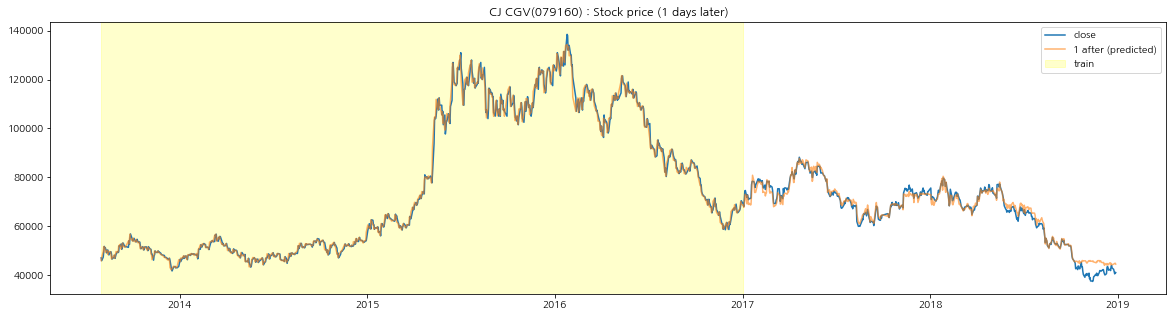

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: UserWarning: Data index is not datetime. Assuming simple periods.


In [102]:
# load data

ticker = target_mtd['코드'][idx_ticker]
stock_price = pd.read_pickle('data/kospi/%s.data' % ticker)
stock_price.index = pd.to_datetime(stock_price.index)
stock_price = stock_price.drop(['Adj Close'], axis=1)
#stock_price = pd.DataFrame(stock_price[['Close']])
#other_components = stock_price[['Open', 'High', 'Low', 'Volume']]
stock_price

# merge wihtout time lag
df = stock_price.merge(df_input, how='inner', left_on=stock_price.index, right_on=df_input.index)
df.index = df['key_0']
df = df.drop(['key_0'], axis=1)

# preprocess (remove object columns)
for idx_day, day in enumerate(['월요일', '화요일', '수요일', '목요일', '금요일']) : 
    df['요일'] = df['요일'].apply(lambda x : idx_day if x==day else x)
for column in df.select_dtypes('object').columns : 
    df[column] = df[column].apply(lambda x : x.replace(',', ''))
    df[column] = pd.to_numeric(df[column])
    
display(df)
df.info()

df_original = copy.deepcopy(df)

# proprocess (if needed)
df = copy.deepcopy(df_original)

# target y (future price)
df['y'] = df['Close'].shift(time_shift)
df = df[df['y'].notnull()]
df = df[df.index <= datetime.datetime(2018,12,31)]

# 1을 상승, 0을 하락
#df['y'] = df.apply(lambda row : 1 if row['y'] > row['Close'] else 0)

# split train/test
y = df['y'] # time-shifted future price
x = df.drop(['y', 'Open', 'High', 'Low'], axis=1) # contains today's price 'Close', 'Volume'
others = df[['Open', 'Close', 'High', 'Low', 'Volume']]
x_columns = x.columns

x_train = x[x.index < datetime.datetime(2017, 1, 1)].values
x_valid = x[x.index >= datetime.datetime(2017, 1, 1)].values
y_train = y[y.index < datetime.datetime(2017, 1, 1)].values
y_valid = y[y.index >= datetime.datetime(2017, 1, 1)].values
others_train = others[others.index < datetime.datetime(2017, 1, 1)]
others_valid = others[others.index >= datetime.datetime(2017, 1, 1)]
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

df

#model

model = lgbm(num_threads=num_threads)
#model = xgb(nthread=num_threads)
#model = cat(thread_count=num_threads, verbose=0)

model.fit(x_train, y_train)

y_train_hat = model.predict(x_train)
y_valid_hat = model.predict(x_valid)

print(r2_score(y_train, y_train_hat), r2_score(y_valid, y_valid_hat))


plt.figure(figsize=(20, 5))
plt.plot(df.index, others['Close'], label='close')
#plt.plot(df.index, pd.concat([pd.Series(y_train), pd.Series(y_valid)], ignore_index=True), label='%s after (close)' % (-time_shift))
plt.plot(df.index, pd.concat([pd.Series(y_train_hat), pd.Series(y_valid_hat)], ignore_index=True), label='%s after (predicted)' % (-time_shift), alpha=0.6)
plt.axvspan(df.index[0], df.index[len(y_train)], alpha=0.2, color='yellow', label='train')
plt.title('%s(%s) : Stock price (%s days later)' % (target_mtd['기업명'][idx_ticker], 
                                                    target_mtd['코드'][idx_ticker],
                                                   -time_shift))
plt.legend()
plt.show()

data = pd.DataFrame(x_valid, columns=x_columns)
data = data.merge(others_valid, how='inner')

yhat = model.predict(data.drop(['Open', 'High', 'Low'], axis=1))
data['time shfited'] = yhat

data

bt = Backtest(data, SmaCross, cash=10000, commission=0)

In [103]:
bt.run()

Start                              0
End                              504
Duration                         504
Exposure [%]                 99.2063
Equity Final [$]             8453.39
Equity Peak [$]              17167.3
Return [%]                  -15.4661
Buy & Hold Return [%]        40.5797
Max. Drawdown [%]            -55.641
Avg. Drawdown [%]            -4.9383
Max. Drawdown Duration           167
Avg. Drawdown Duration       17.5263
# Trades                         200
Win Rate [%]                    54.5
Best Trade [%]               12.4088
Worst Trade [%]             -12.2402
Avg. Trade [%]            -0.0596714
Max. Trade Duration                4
Avg. Trade Duration              2.5
Expectancy [%]               2.77329
SQN                        -0.251825
Sharpe Ratio              -0.0161391
Sortino Ratio             -0.0209866
Calmar Ratio             -0.00107244
_strategy                   SmaCross
dtype: object

In [104]:
bt.plot()